Crear set de datos

In [2]:
import pandas as pd

# Cargar los archivos con el separador adecuado (tabulación)
entities_df = pd.read_csv('entities_train.csv', sep='\t')
abstracts_df = pd.read_csv('abstracts_train.csv', sep='\t')
relations_df = pd.read_csv('relations_train.csv', sep='\t')

# Asegurarse de que todos los identificadores de 'abstract_id' sean strings
entities_df['abstract_id'] = entities_df['abstract_id'].astype(str)
abstracts_df['abstract_id'] = abstracts_df['abstract_id'].astype(str)
relations_df['abstract_id'] = relations_df['abstract_id'].astype(str)

# Unir los resúmenes con las relaciones usando 'abstract_id'
merged_df = pd.merge(relations_df, abstracts_df[['abstract_id', 'abstract', 'title']], on='abstract_id', how='inner')

# Unir la información de las entidades, primero para 'entity_1' y luego para 'entity_2'
merged_df = pd.merge(merged_df, entities_df[['entity_ids', 'mention', 'type', 'abstract_id']],
                     left_on=['abstract_id', 'entity_1_id'],
                     right_on=['abstract_id', 'entity_ids'],
                     how='inner')

# Renombrar las columnas para la entidad 1
merged_df.rename(columns={'mention': 'entity_1_mention', 'type': 'entity_1_type'}, inplace=True)

# Unir nuevamente con las entidades para obtener la entidad 2
merged_df = pd.merge(merged_df, entities_df[['entity_ids', 'mention', 'type', 'abstract_id']],
                     left_on=['abstract_id', 'entity_2_id'],
                     right_on=['abstract_id', 'entity_ids'],
                     how='inner')

# Renombrar las columnas para la entidad 2
merged_df.rename(columns={'mention': 'entity_2_mention', 'type': 'entity_2_type'}, inplace=True)

# Revisar las columnas después de las fusiones para identificar los nombres correctos
print("Columnas disponibles después de la fusión:", merged_df.columns)


# Verificar el DataFrame de entrenamiento
print(merged_df.head())

# Guardar el DataFrame en un archivo CSV para futuros usos



Columnas disponibles después de la fusión: Index(['id', 'abstract_id', 'type_x', 'entity_1_id', 'entity_2_id', 'novel',
       'abstract', 'title', 'entity_ids_x', 'entity_1_mention', 'type_y',
       'entity_ids_y', 'entity_2_mention', 'entity_2_type'],
      dtype='object')
   id abstract_id       type_x entity_1_id entity_2_id novel  \
0   0     1353340  Association         410     D007966    No   
1   0     1353340  Association         410     D007966    No   
2   0     1353340  Association         410     D007966    No   
3   0     1353340  Association         410     D007966    No   
4   0     1353340  Association         410     D007966    No   

                                            abstract  \
0  We report on a new allele at the arylsulfatase...   
1  We report on a new allele at the arylsulfatase...   
2  We report on a new allele at the arylsulfatase...   
3  We report on a new allele at the arylsulfatase...   
4  We report on a new allele at the arylsulfatase...   

 

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73910 entries, 0 to 73909
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                73910 non-null  int64 
 1   abstract_id       73910 non-null  object
 2   type_x            73910 non-null  object
 3   entity_1_id       73910 non-null  object
 4   entity_2_id       73910 non-null  object
 5   novel             73910 non-null  object
 6   abstract          73910 non-null  object
 7   title             73910 non-null  object
 8   entity_ids_x      73910 non-null  object
 9   entity_1_mention  73910 non-null  object
 10  type_y            73910 non-null  object
 11  entity_ids_y      73910 non-null  object
 12  entity_2_mention  73910 non-null  object
 13  entity_2_type     73910 non-null  object
dtypes: int64(1), object(13)
memory usage: 7.9+ MB


In [3]:
import pandas as pd



# Función para calcular la distancia entre dos menciones en el texto
def calculate_mention_distance(row):
    abstract_text = row['abstract']
    entity_1_mention = row['entity_1_mention']
    entity_2_mention = row['entity_2_mention']

    # Encontrar las posiciones de las menciones de entity_1 y entity_2 dentro del abstract
    entity_1_pos = abstract_text.find(entity_1_mention)
    entity_2_pos = abstract_text.find(entity_2_mention)

    # Si alguna de las entidades no es encontrada, se retorna None
    if entity_1_pos == -1 or entity_2_pos == -1:
        return None

    # Calcular la distancia como la diferencia entre las posiciones iniciales de las menciones
    distance = abs(entity_1_pos - entity_2_pos)
    return distance

# Aplicar la función para calcular la distancia en cada fila del DataFrame
merged_df['mention_distance'] = merged_df.apply(calculate_mention_distance, axis=1)

# Calcular la distancia media ignorando los valores nulos
mean_distance = merged_df['mention_distance'].mean()

# Mostrar la distancia media
print(f"Distancia media entre las menciones de entity_1 y entity_2: {mean_distance}")


Distancia media entre las menciones de entity_1 y entity_2: 443.54988253719654


In [4]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Asumiendo que merged_df ya está creado y contiene las columnas 'abstract' y 'type_x' (que es la relación)

# 1. Convertir los abstracts a minúsculas
merged_df['abstract'] = merged_df['abstract'].str.lower()

# Verificar que se haya hecho la conversión a minúsculas
print("Abstracts en minúsculas:\n", merged_df['abstract'].head())

# 2. Tokenización y Padding

# Parámetros de tokenización
max_words = 10000  # Número máximo de palabras a mantener en el vocabulario
max_len = 100  # Longitud máxima de las secuencias (después del padding)

# Crear el tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")  # OOV es para palabras fuera del vocabulario
tokenizer.fit_on_texts(merged_df['abstract'])

# Convertir los abstracts a secuencias de tokens
sequences = tokenizer.texts_to_sequences(merged_df['abstract'])

# Aplicar padding a las secuencias para que todas tengan la misma longitud
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Verificar las primeras secuencias tokenizadas y con padding
print("Primeras secuencias tokenizadas y con padding:\n", padded_sequences[:5])

# 3. Preparar las etiquetas (Relation Type)
# Convertir las relaciones en etiquetas numéricas usando LabelEncoder
label_encoder = LabelEncoder()
merged_df['type_x'] = label_encoder.fit_transform(merged_df['type_x'])

# Verificar las etiquetas convertidas
print("Etiquetas de relación convertidas a números:\n", merged_df['type_x'].head())

# Ahora tienes `padded_sequences` (que es la entrada para el modelo) y las etiquetas numéricas `merged_df['type_x']`

# Verificación final
print("Tamaño del conjunto de secuencias con padding:", padded_sequences.shape)
print("Tamaño del conjunto de etiquetas:", merged_df['type_x'].shape)


Abstracts en minúsculas:
 0    we report on a new allele at the arylsulfatase...
1    we report on a new allele at the arylsulfatase...
2    we report on a new allele at the arylsulfatase...
3    we report on a new allele at the arylsulfatase...
4    we report on a new allele at the arylsulfatase...
Name: abstract, dtype: object
Primeras secuencias tokenizadas y con padding:
 [[  22  416   24    7  372  129   49    2 8097    7 6885  781 1271 4842
   475 9347 9348 6886    5   11  129 8376    7 1498   11   15  686 2694
     5    2 8097   29  183   15 6039   13 1562    5  490    8  786   11
   455  766  475 6886    2 8376    8 1562  299   15   33    6  501 4538
  6885   82    7 1002    4  841 6885  526    3  169  133   24   42  339
  1078    2  129    4 3054   20    6 6886  252  227 9349    2 7691   11
   267 5027    4 4538 6885   82   44    2 1262    4 7506 1050    5 6886
     0    0]
 [  22  416   24    7  372  129   49    2 8097    7 6885  781 1271 4842
   475 9347 9348 6886    5   11 

LSTM

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Parámetros del modelo
vocab_size = 10000  # Tamaño del vocabulario
embedding_dim = 128  # Dimensionalidad del embedding
max_len = 150  # Longitud máxima de las secuencias
dropout_rate = 0.5  # Tasa de Dropout
l2_reg = 0.01  # Regularización L2
learning_rate = 1e-4  # Tasa de aprendizaje ajustada

# Construir el modelo secuencial
model = Sequential()

# 1. Capa de Embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# 2. Capa Bidirectional LSTM
model.add(Bidirectional(LSTM(128, return_sequences=True)))

# 3. Segunda capa LSTM
model.add(LSTM(64, return_sequences=False))

# 4. Capa de Dropout
model.add(Dropout(dropout_rate))

# 5. Capa de clasificación con regularización L2
num_classes = len(label_encoder.classes_)  # Número de clases (relaciones)
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg)))

# Compilar el modelo con optimizador Adam
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Resumen del modelo
model.summary()

# Early Stopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo con Early Stopping
history = model.fit(padded_sequences, merged_df['type_x'], epochs=10, batch_size=32, validation_split=0.3, callbacks=[early_stopping])

# Evaluar el modelo
loss, accuracy = model.evaluate(padded_sequences_val, val_labels)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 787s 479ms/step - accuracy: 0.5456 - loss: 1.3614 - val_accuracy: 0.4320 - val_loss: 1.4082
Epoch 2/10
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 805s 481ms/step - accuracy: 0.6578 - loss: 0.9221 - val_accuracy: 0.4997 - val_loss: 1.4031
Epoch 3/10
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 823s 494ms/step - accuracy: 0.6664 - loss: 0.8663 - val_accuracy: 0.4453 - val_loss: 1.3143
Epoch 4/10
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 783s 485ms/step - accuracy: 0.6617 - loss: 0.8452 - val_accuracy: 0.4435 - val_loss: 1.3932
Epoch 5/10
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 764s 473ms/step - accuracy: 0.6679 - loss: 0.8242 - val_accuracy: 0.4672 - val_loss: 1.3351
Epoch 6/10
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 803s 473ms/step - accuracy: 0.6715 - loss: 0.8077 - val_accuracy: 0.5053 - val_loss: 1.3585
Epoch 7/10
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 858s 508ms/step - accuracy: 0.6696 - loss: 0.7982 - val_accuracy: 0.4154 - val_loss: 1.2916
Epoch 8/10
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 797s 468ms/step - ac

NameError: name 'padded_sequences_val' is not defined

In [9]:
import shap
import numpy as np
# Guardar el modelo entrenado en formato HDF5
model.save("modelo_lstm_bidireccional.h5")

# Alternativamente, guardar en formato TensorFlow SavedModel

# Crear el explainer de SHAP para el modelo entrenado
# Nota: utilizamos KernelExplainer, que puede ser lento en función del tamaño de los datos
explainer = shap.KernelExplainer(model.predict, padded_sequences[:100])  # Usa una muestra de datos para SHAP

# Obtener los valores SHAP para una muestra de predicciones (por ejemplo, las primeras 5 instancias)
shap_values = explainer.shap_values(padded_sequences[:5])

# Visualizar los valores SHAP para la primera muestra
shap.initjs()

# Ajustar la visualización con solo un shap_value por clase en caso de clasificaciones multiclase
for i in range(len(shap_values[0])):  # Asegúrate de usar una muestra pequeña para la visualización
    shap.force_plot(
        explainer.expected_value[0],  # Para una sola clase, selecciona el valor esperado de la primera clase
        shap_values[0][i],  # Ajusta con shap_values[0] para una salida específica
        padded_sequences[i]  # La entrada correspondiente en padded_sequences
    )

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 470ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
7025/7025 ━━━━━━━━━━━━━━━━━━━━ 924s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
7025/7025 ━━━━━━━━━━━━━━━━━━━━ 919s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
7025/7025 ━━━━━━━━━━━━━━━━━━━━ 916s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
7025/7025 ━━━━━━━━━━━━━━━━━━━━ 925s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7025/7025 ━━━━━━━━━━━━━━━━━━━━ 923s 131ms/step


DimensionError: Length of features is not equal to the length of shap_values!

In [12]:
import shap
import numpy as np

# Usar una muestra aleatoria de las secuencias con un tamaño reducido
sample_size = 100  # Puedes ajustar el tamaño de muestra según tus necesidades
sample_indices = np.random.choice(len(padded_sequences), sample_size, replace=False)
sample_sequences = padded_sequences[sample_indices]

# Crear el explainer y generar valores SHAP solo para la muestra
explainer = shap.KernelExplainer(model.predict, sample_sequences)
shap_values = explainer.shap_values(sample_sequences)

# Generar el summary plot para la muestra
shap.summary_plot(shap_values[0], sample_sequences, plot_type="bar")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
7025/7025 ━━━━━━━━━━━━━━━━━━━━ 915s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
7025/7025 ━━━━━━━━━━━━━━━━━━━━ 910s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
 546/7025 ━━━━━━━━━━━━━━━━━━━━ 14:01 130ms/step

KeyboardInterrupt: 

In [ ]:
# Evaluar el modelo en los datos de validación
loss, accuracy = model.evaluate(padded_sequences, merged_df['type_x'], verbose=2)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


NameError: name 'model' is not defined

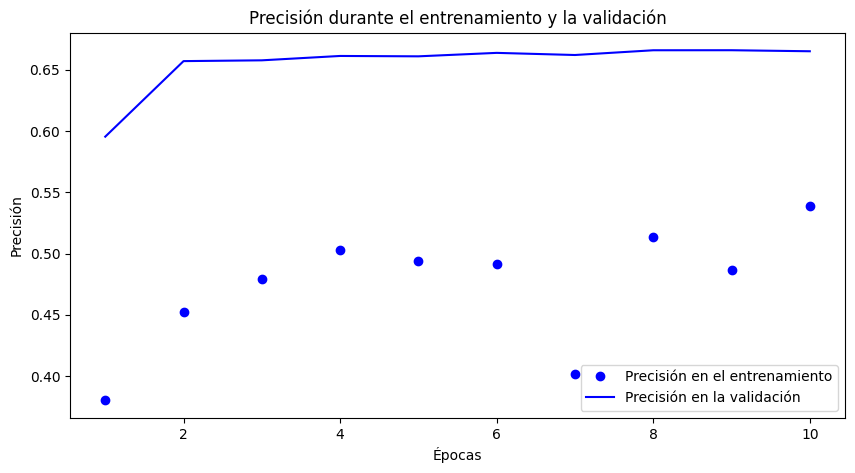

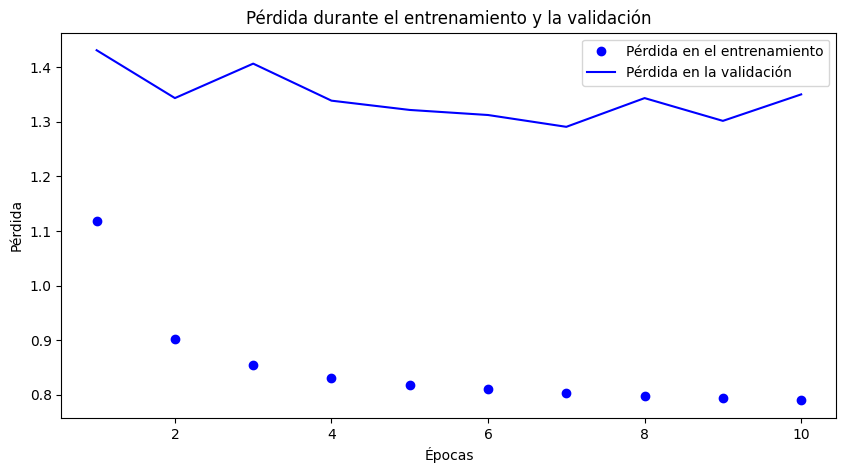

In [ ]:
import matplotlib.pyplot as plt

# Extraer los datos de precisión y pérdida del historial de entrenamiento
history_dict = history.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(accuracy) + 1)

# Graficar la precisión
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracy, 'bo', label='Precisión en el entrenamiento')
plt.plot(epochs,accuracy, 'b', label='Precisión en la validación')
plt.title('Precisión durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida en la validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


RNN

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Parámetros del modelo
vocab_size = 10000  # Tamaño del vocabulario
embedding_dim = 128  # Dimensión del embedding (aumentada para mejorar el aprendizaje)
max_len = 100  # Longitud máxima de las secuencias
dropout_rate = 0.5  # Tasa de Dropout
num_classes = len(label_encoder.classes_)  # Número de clases (relaciones)
learning_rate = 1e-4  # Tasa de aprendizaje ajustada

# Construir el modelo secuencial
model_rnn = Sequential()

# 1. Capa de Embedding
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# 2. Capa Bidirectional RNN
model_rnn.add(Bidirectional(SimpleRNN(128, return_sequences=True)))  # Añadir una RNN bidireccional

# 3. Segunda capa RNN
model_rnn.add(SimpleRNN(64, return_sequences=False))  # Segunda capa RNN

# 4. Capa de Dropout
model_rnn.add(Dropout(dropout_rate))

# 5. Capa densa con regularización L2
model_rnn.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01)))

# Compilar el modelo con Adam
optimizer = Adam(learning_rate=learning_rate)
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Resumen del modelo
model_rnn.summary()

# Entrenar el modelo
history_rnn = model_rnn.fit(padded_sequences, merged_df['type_x'], epochs=10, batch_size=32, validation_split=0.2)
model_rnn.save("modelo_rnn_bidireccional.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 254s 131ms/step - accuracy: 0.5577 - loss: 1.2521 - val_accuracy: 0.5023 - val_loss: 1.2839
Epoch 2/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 261s 131ms/step - accuracy: 0.6511 - loss: 0.8978 - val_accuracy: 0.4593 - val_loss: 1.2670
Epoch 3/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 272s 136ms/step - accuracy: 0.6545 - loss: 0.8520 - val_accuracy: 0.5547 - val_loss: 1.1863
Epoch 4/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 257s 134ms/step - accuracy: 0.6509 - loss: 0.8366 - val_accuracy: 0.5459 - val_loss: 1.1815
Epoch 5/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 273s 140ms/step - accuracy: 0.6561 - loss: 0.8150 - val_accuracy: 0.4554 - val_loss: 1.1834
Epoch 6/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 251s 134ms/step - accuracy: 0.6602 - loss: 0.8060 - val_accuracy: 0.5255 - val_loss: 1.1842
Epoch 7/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 260s 133ms/step - accuracy: 0.6615 - loss: 0.7997 - val_accuracy: 0.5415 - val_loss: 1.1635
Epoch 8/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 260s 132ms/step - ac

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Supongamos que `X_val` y `y_val` son tu conjunto de validación (entradas y etiquetas verdaderas)

# 1. Genera las predicciones en el conjunto de validación
y_val_pred_proba = model_rnn.predict(X_val)  # Esto genera las probabilidades de cada clase
y_val_pred_classes = np.argmax(y_val_pred_proba, axis=1)  # Convierte las probabilidades en clases

# 2. Calcula las métricas
val_accuracy = accuracy_score(y_test, y_val_pred_classes)
val_precision = precision_score(y_val, y_val_pred_classes, average='weighted', zero_division=0)
val_recall = recall_score(y_val, y_val_pred_classes, average='weighted')
val_f1 = f1_score(y_val, y_val_pred_classes, average='weighted')

# 3. Imprime las métricas
print(f"Precisión en la validación: {val_accuracy:.4f}")
print(f"Precisión (weighted) en la validación: {val_precision:.4f}")
print(f"Recall (weighted) en la validación: {val_recall:.4f}")
print(f"F1-Score (weighted) en la validación: {val_f1:.4f}")


NameError: name 'X_val' is not defined

In [ ]:
# Evaluar el modelo RNN en los datos de validación
loss_rnn, accuracy_rnn = model_rnn.evaluate(padded_sequences, merged_df['type_x'], verbose=2)
print(f"Loss (RNN): {loss_rnn}")
print(f"Accuracy (RNN): {accuracy_rnn}")


2310/2310 - 16s - 7ms/step - accuracy: 0.6326 - loss: 0.7970
Loss (RNN): 0.797034740447998
Accuracy (RNN): 0.6325801610946655


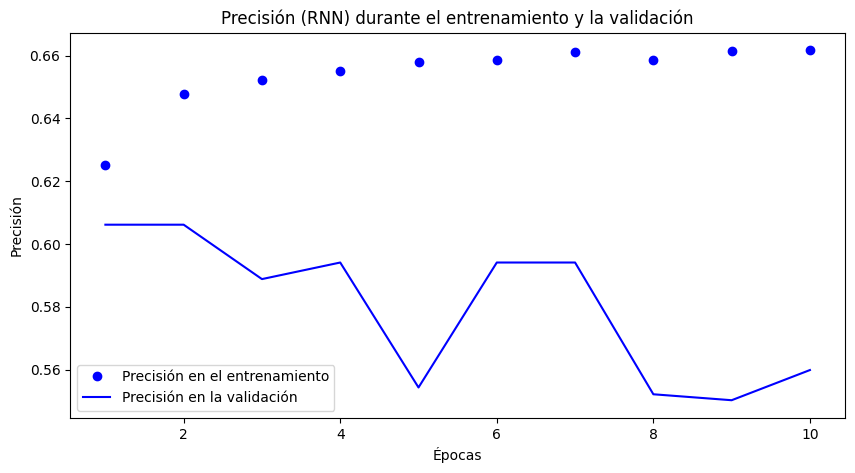

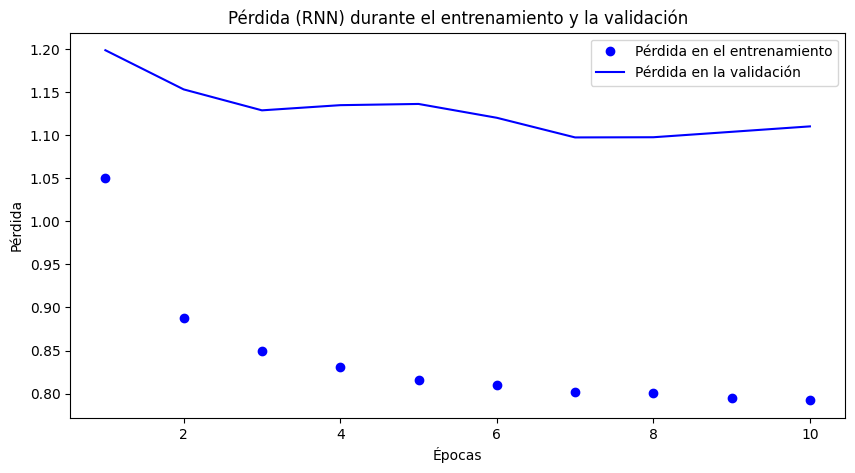

In [ ]:
import matplotlib.pyplot as plt

# Extraer los datos de precisión y pérdida del historial de entrenamiento del RNN
history_dict_rnn = history_rnn.history
accuracy_rnn = history_dict_rnn['accuracy']
val_accuracy_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs = range(1, len(accuracy_rnn) + 1)

# Graficar la precisión (RNN)
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_rnn, 'bo', label='Precisión en el entrenamiento')
plt.plot(epochs, val_accuracy_rnn, 'b', label='Precisión en la validación')
plt.title('Precisión (RNN) durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida (RNN)
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_rnn, 'bo', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss_rnn, 'b', label='Pérdida en la validación')
plt.title('Pérdida (RNN) durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()



GPT

In [14]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Attention, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



# Añadir delimitadores para las entidades en el texto del abstract
merged_df['input_text'] = merged_df.apply(
    lambda row: f"Context: {row['abstract']} \nRelationship between [ENTITY_1] {row['entity_1_mention']} and [ENTITY_2] {row['entity_2_mention']}.",
    axis=1
)

# Codificar las etiquetas de clase
label_encoder = LabelEncoder()
merged_df['type_x'] = label_encoder.fit_transform(merged_df['type_x'])

# Dividir en conjunto de entrenamiento y prueba
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

# Tokenización y padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['input_text'])
X_train = tokenizer.texts_to_sequences(train_df['input_text'])
X_test = tokenizer.texts_to_sequences(test_df['input_text'])

# Padding de secuencias
max_len = 150
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

# Obtener las etiquetas
y_train = train_df['type_x'].values
y_test = test_df['type_x'].values

# Paso 2: Implementar el modelo Attention-Based CNN

# Definir el input layer
input_layer = Input(shape=(max_len,))
from tensorflow.keras.layers import Lambda

# Capa de embedding
embedding_dim = 128
embedding_layer = Embedding(input_dim=10000, output_dim=embedding_dim)(input_layer)

# Capa convolucional con filtros y tamaños de kernel adecuados para capturar patrones locales
conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)

# Expandir dimensiones usando Lambda para crear un tensor compatible con Keras
attention_input = Lambda(lambda x: tf.expand_dims(x, axis=1))(pooling_layer)

# Capa de atención
attention_layer = Attention()([attention_input, attention_input])
attention_output = Flatten()(attention_layer)

# Capa densa con dropout para evitar el sobreajuste
dropout_rate = 0.5
dense_layer = Dense(64, activation='relu')(attention_output)
dropout_layer = Dropout(dropout_rate)(dense_layer)

# Capa de salida con softmax para clasificación multiclase
num_classes = len(label_encoder.classes_)
output_layer = Dense(num_classes, activation='softmax')(dropout_layer)

# Definir el modelo
model = Model(inputs=input_layer, outputs=output_layer)

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Ver el resumen del modelo
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 150)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 150, 128)       │      1,280,000 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 146, 128)       │         82,048 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 128)            │              0 │ conv1d_1[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1, 128)         │              0 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 1, 128)         │              0 │ lambda_1[0][0],        │
│                           │                        │                │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 128)            │              0 │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          8,256 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 8)              │            520 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,370,824 (5.23 MB)

 Trainable params: 1,370,824 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1479/1479 ━━━━━━━━━━━━━━━━━━━━ 114s 76ms/step - accuracy: 0.6569 - loss: 0.8995 - val_accuracy: 0.9301 - val_loss: 0.2033
Epoch 2/10
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 138s 73ms/step - accuracy: 0.9461 - loss: 0.1710 - val_accuracy: 0.9721 - val_loss: 0.0867
Epoch 3/10
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 144s 74ms/step - accuracy: 0.9731 - loss: 0.0853 - val_accuracy: 0.9822 - val_loss: 0.0564
Epoch 4/10
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 139s 72ms/step - accuracy: 0.9798 - loss: 0.0609 - val_accuracy: 0.9838 - val_loss: 0.0474
Epoch 5/10
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 146s 75ms/step - accuracy: 0.9835 - loss: 0.0498 - val_accuracy: 0.9879 - val_loss: 0.0375
Epoch 6/10
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 138s 73ms/step - accuracy: 0.9870 - loss: 0.0387 - val_accuracy: 0.9878 - val_loss: 0.0408
Epoch 7/10
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 108s 73ms/step - accuracy: 0.9872 - loss: 0.0355 - val_accuracy: 0.9908 - val_loss: 0.0439
Epoch 8/10
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 142s 73ms/step - accuracy: 0.9903 - lo

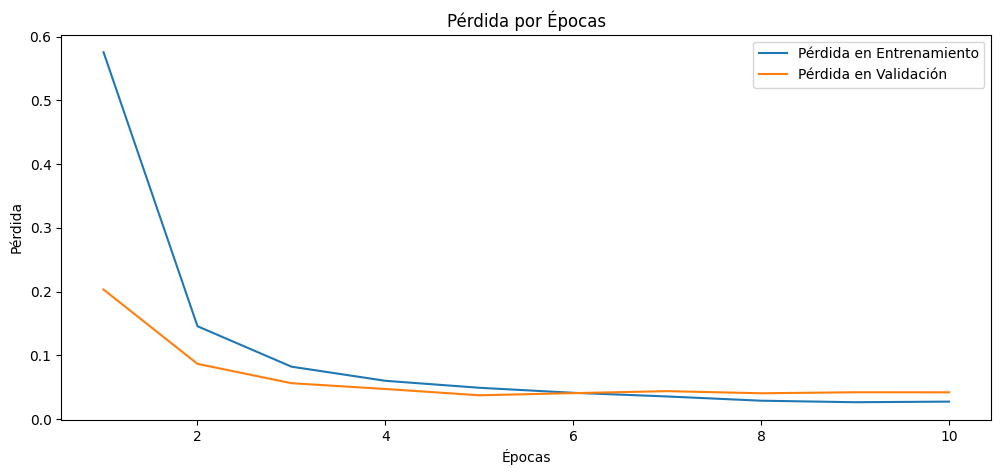

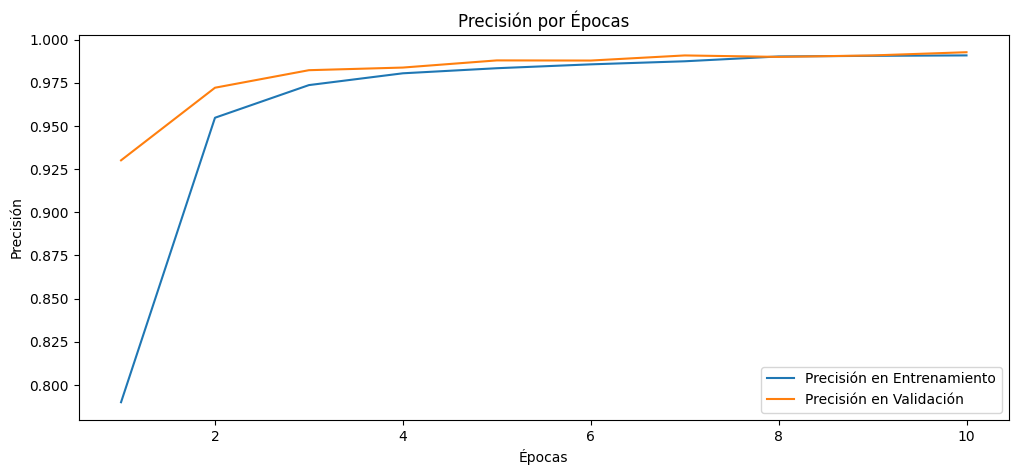

In [15]:
import matplotlib.pyplot as plt
# Número de épocas y tamaño de lote
epochs = 10
batch_size = 32



# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Extraer la información del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(1, epochs + 1)


# Guardar el modelo en formato HDF5
model.save("modelo_attention_cnn.h5")
# Graficar la pérdida
plt.figure(figsize=(12, 5))
plt.plot(epochs_range, train_loss, label='Pérdida en Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida en Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida por Épocas')
plt.legend()
plt.show()

# Graficar la precisión
plt.figure(figsize=(12, 5))
plt.plot(epochs_range, train_accuracy, label='Precisión en Entrenamiento')
plt.plot(epochs_range, val_accuracy, label='Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión por Épocas')
plt.legend()
plt.show()


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
7338/7338 ━━━━━━━━━━━━━━━━━━━━ 134s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
7338/7338 ━━━━━━━━━━━━━━━━━━━━ 129s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
7338/7338 ━━━━━━━━━━━━━━━━━━━━ 130s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
7338/7338 ━━━━━━━━━━━━━━━━━━━━ 129s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
7338/7338 ━━━━━━━━━━━━━━━━━━━━ 130s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7338/7338 ━━━━━━━━━━━━━━━━━━━━ 128s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7338/7338 ━━━━━━━━━━━━━━━━━━━━ 130s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7338/7338 ━━━━━━━━━━━━━━━━━━━━ 129s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
7338/7338 ━━━━━━━━━━━━━━━━━━━━ 132s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7338/7338 ━━━━━━━━━━━━━━━━━━━━ 129s 18ms/step


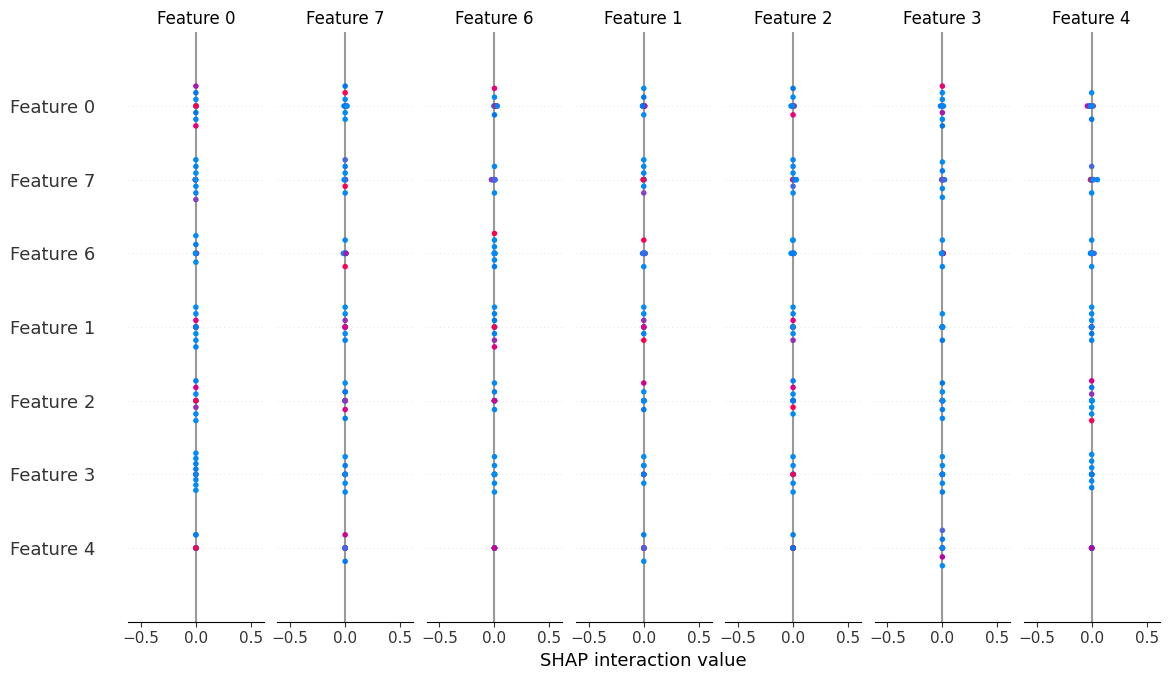

In [18]:
import shap

# Crear el explainer usando KernelExplainer con una muestra pequeña
explainer = shap.KernelExplainer(model.predict, X_train[:100])

# Generar los valores SHAP para una muestra pequeña del conjunto de prueba
shap_values = explainer.shap_values(X_test[:10])

# Summary plot para mostrar la importancia de las características
shap.summary_plot(shap_values, X_test[:10], plot_type="bar")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


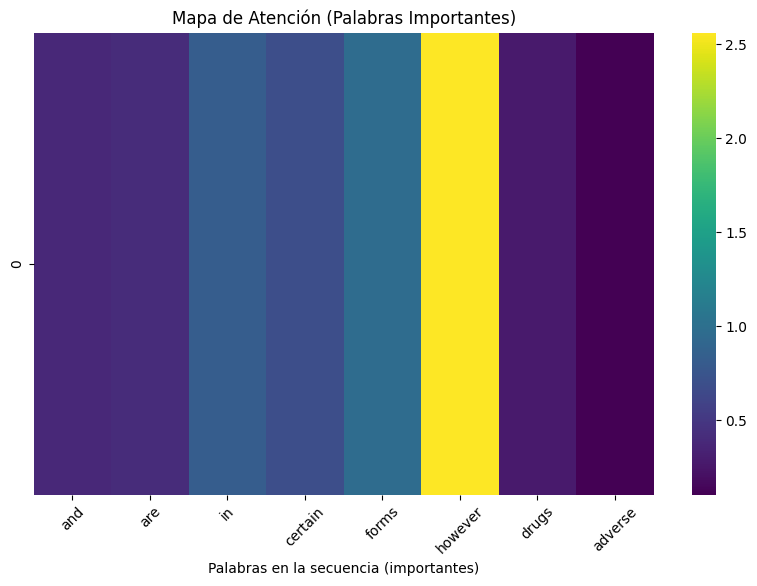

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Función para visualizar el mapa de atención con palabras importantes
def plot_attention_map(model, input_text, tokenizer, max_len, attention_threshold=0.1):
    """
    Dibuja el mapa de atención para una secuencia de entrada dada, mostrando solo palabras con pesos altos.

    Args:
        model (tf.keras.Model): El modelo que contiene la capa de atención.
        input_text (str): El texto de entrada.
        tokenizer (Tokenizer): El tokenizer utilizado para convertir el texto en secuencias.
        max_len (int): La longitud máxima de secuencia para padding.
        attention_threshold (float): Umbral de atención. Solo se mostrarán palabras con atención superior a este valor.
    """
    # Tokenización y padding de la secuencia de entrada
    sequence = tokenizer.texts_to_sequences([input_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

    # Crear un modelo intermedio que obtenga la salida de la capa de atención
    attention_layer_model = Model(inputs=model.input, outputs=model.get_layer('attention_1').output)

    # Obtener los pesos de atención
    attention_weights = attention_layer_model.predict(padded_sequence)
    attention_weights = attention_weights.squeeze()  # Eliminar dimensiones extra

    # Obtener las palabras de la secuencia tokenizada
    words = tokenizer.sequences_to_texts([sequence[0]])[0].split()

    # Ajustar las palabras para que coincidan con la longitud de secuencia máxima
    if len(words) < max_len:
        words += ['<PAD>'] * (max_len - len(words))

    # Filtrar palabras según el umbral de atención
    important_words = []
    important_weights = []
    for word, weight in zip(words, attention_weights):
        if weight > attention_threshold and word != '<PAD>':  # Filtra palabras con alta atención y excluye padding
            important_words.append(word)
            important_weights.append(weight)

    # Visualizar el mapa de atención con palabras importantes
    plt.figure(figsize=(10, 6))
    sns.heatmap([important_weights], xticklabels=important_words, cmap='viridis', cbar=True)
    plt.xlabel('Palabras en la secuencia (importantes)')
    plt.title('Mapa de Atención (Palabras Importantes)')
    plt.xticks(rotation=45)
    plt.show()


# Ejemplo de uso con tu modelo:
input_text = "Carbamazepine and vigabatrin are contraindicated in certain forms of epilepsy. However, these drugs are sometimes prescribed inappropriately, which can lead to adverse effects and ineffective treatment outcomes."
plot_attention_map(model, input_text, tokenizer, max_len)
